In [30]:
import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler



import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

## 2. Preprocesing B
### 2.1 Reinspect Data

In [2]:
data = pd.read_csv('../app/data/wrangled_data.csv')
# 2.2.1 Inspect Table
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       1510 non-null   object 
 1   description   1510 non-null   object 
 2   location      1510 non-null   object 
 3   rating        1510 non-null   float64
 4   requirements  187 non-null    object 
 5   summary       1510 non-null   object 
 6   job_title     1510 non-null   object 
 7   url           1510 non-null   object 
 8   text          1510 non-null   object 
 9   salary        1124 non-null   float64
 10  dateposted    1510 non-null   object 
 11  state         1510 non-null   object 
 12  city          1510 non-null   object 
dtypes: float64(2), object(11)
memory usage: 24.5 MB


,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,online technical services,"job descriptiondata scientist, marketingsan di...",remote,3.7,master's (preferred)python: 1 year (preferred)...,identify relevant data sources and data sets t...,data scientist - marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"job descriptiondata scientist, marketingsan di...",148000.0,2022-04-13,remote,remote
1,west cap,human was founded in 2012 in a brooklyn sci-fi...,"remote in new york, ny+2 locations",3.5,NaN,you’ve worked as a data scientist solving larg...,"data scientist, botguard",https://www.indeed.com/rc/clk?jk=58cdde046f643...,human was founded in 2012 in a brooklyn sci-fi...,129000.0,2022-04-13,ny,remote in new york
2,maya ai inc.,our maya team is expanding and we are looking ...,remote,0.0,python: 1 year (preferred)sql: 1 year (preferred),our analyst will be dealing with data coming i...,data scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...,our maya team is expanding and we are looking ...,131000.0,2022-04-13,remote,remote
3,"emergetech, inc",description:job categorydata scienceabout emer...,remote,0.0,NaN,design and create the data sources that ”citiz...,data scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...,description:job categorydata scienceabout emer...,107000.0,2022-04-13,remote,remote
4,recurrent,what's the opportunity?recurrent is on a missi...,"remote in seattle, wa",0.0,NaN,experienced - you have 2+ years of experience ...,data scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...,what's the opportunity?recurrent is on a missi...,135000.0,2022-04-13,wa,remote in seattle


From the info table I can see that the only missing values are for the Salary target feature.However, for duplicates it would 'seem' that almost all of my data is duplicated.\
It appears this way because an absolutely distinguishing feature has been removed, the url. That's what these duplicates are, individual records for multiple openings (records/observations,singular data). How this affects NLP and ML will be part of the ongoing discovery process.

In [3]:
print(data.company.unique()[:10])

['online technical services' 'west cap' 'maya ai inc.' 'emergetech, inc'
 'recurrent' 'fractal.ai' 'techtrueup' 'eab' 'ford motor company' 'redfin']


In [4]:
data.describe(include='all')

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
count,1510,1510,1510,1510.000000,187,1510,1510,1510,1510,1124.000000,1510,1510,1510
unique,96,118,82,NaN,10,164,87,297,172,NaN,7,30,51
top,sparkcognition,we are currently seeking a senior data scienti...,remote,NaN,master's (preferred)python: 3 years (preferred...,"mentor and grow other software engineers, data...",data scientist,https://www.indeed.com/company/nThrive/jobs/Le...,we are currently seeking a senior data scienti...,NaN,2022-04-16,remote,remote
freq,80,69,386,NaN,39,68,348,39,68,NaN,376,386,386
mean,NaN,NaN,NaN,2.518079,NaN,NaN,NaN,NaN,NaN,127310.498221,NaN,NaN,NaN
std,NaN,NaN,NaN,1.781585,NaN,NaN,NaN,NaN,NaN,33753.818241,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,54000.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,104000.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,NaN,130000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,3.900000,NaN,NaN,NaN,NaN,NaN,148000.000000,NaN,NaN,NaN


In [5]:
(114 + 144)/2

129.0

### 2.2 Univariate Feature Analysis & Centering
I'm going to employ visual and statistical methods to analyze each feature, starting with the target, and outside of scaling, prepare them for logistic regression which will require that each feature's vaues are normally distributes.


### 2.2a Target

In [6]:
col = 'salary'
eda_data = data[data[col]>1]

### Detecting Outliers: Using both the Z-Score and IQR methods
Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

To explore the possibility of outliers I'll start with a box and whisker plot. Those whisters reach 1.5 times past the IQR boundary on either side, and are generally provide a good means of identifying outliers - values beyond the boundaries.

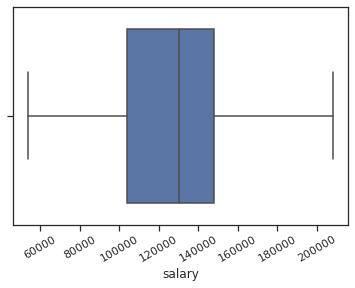

In [7]:
sns.boxplot(data=eda_data, x='salary')
plt.xticks(rotation=30)
plt.show()

To observe the impact this has on the target's shape I'll employ a KDE plot.

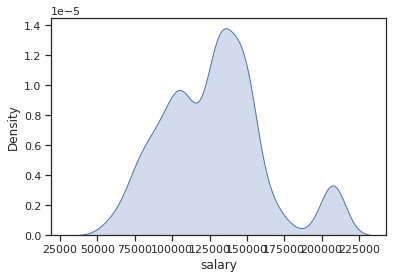

In [8]:
sns.kdeplot(eda_data.salary, shade=True)
plt.show()

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.\
Here we can see that there are five records with salary values outside the Z-score threshold.

In [9]:
outliers = []
def z_detect(data):
    sample = data[data['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(data)

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.\
Here, I clearly demarcate the quartiles as well as the uppet and lower boundaries. Before removing these outliers let's take a look.

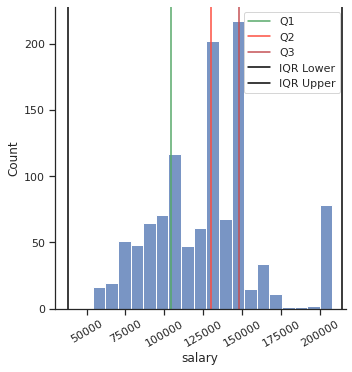

In [10]:
q1 = np.quantile(eda_data.salary, 0.25)
q2 = np.quantile(eda_data.salary, 0.5)
q3 = np.quantile(eda_data.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(eda_data.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

There aren't any outliers beyond the lower bound for either test so let's take a look at what's above the IQR threshold.\
While not guarenteed, its a good thing that both tests seem to identify the same five records, the salary values match.

In [11]:
data[data.salary > iqr_upper]

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city


Trimming the data, while showing the number of records were starting with and how many remain after removing the outliers viewed above.

In [12]:
print(len(data))
data1 = data[data.salary <= iqr_upper]
data2 = data[data.salary.isnull()]
data = pd.concat([data1,data2])
print(len(data))
eda_data = data[data[col]>1]

1510
1510


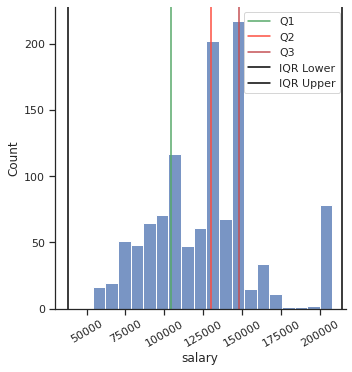

In [13]:
q1 = np.quantile(eda_data.salary, 0.25)
q2 = np.quantile(eda_data.salary, 0.5)
q3 = np.quantile(eda_data.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(eda_data.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.xticks(rotation=30)
plt.show()

Excellent, everything falls within the boundaries. While there are a number of reccords off in the high end, neither test detects them as outliers, let's check with a box and whisker plot though.

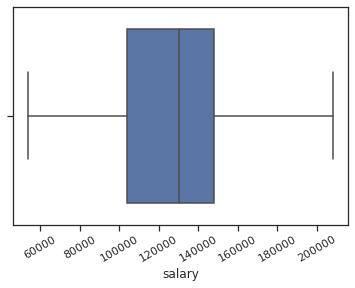

In [14]:
sns.boxplot(data=data, x='salary')
plt.xticks(rotation=30)
plt.show()

Modality might be an issue but it's something I can come back and fine tune later.

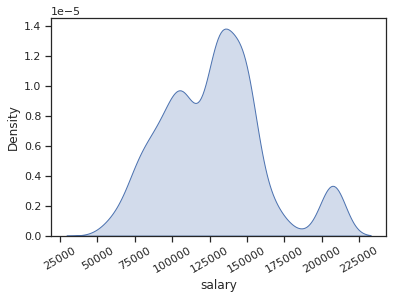

In [15]:
#TODO check on this modality.
sns.kdeplot(eda_data.salary, shade=True)
plt.xticks(rotation=30)
plt.show()

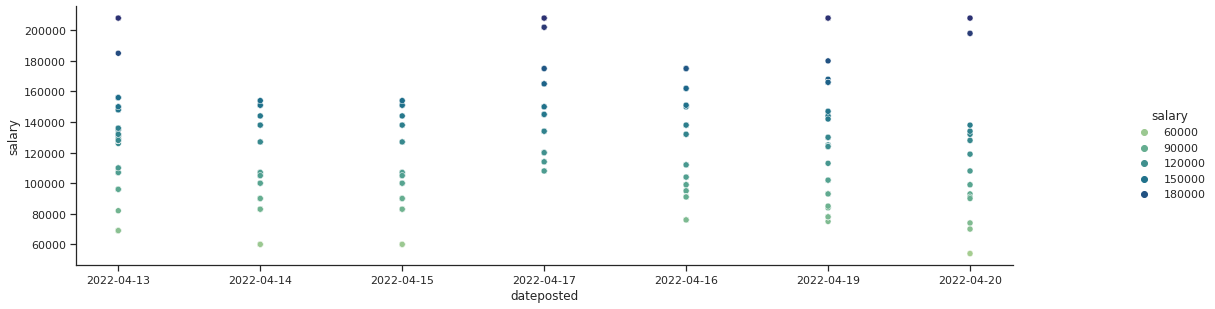

In [16]:
ax = sns.pairplot(data=data[data.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

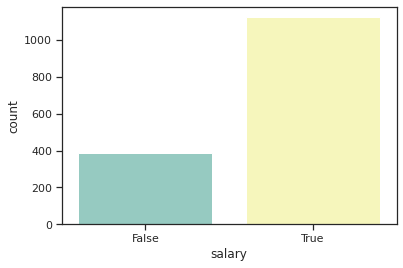

In [17]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()


In [18]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

74.44% of the data has salary information, should be an easy target


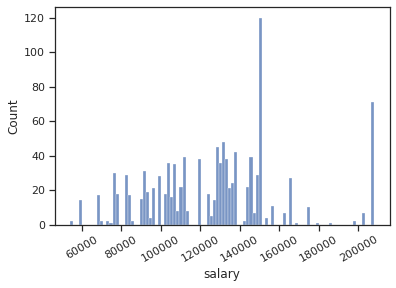

In [19]:
sns.histplot(data,x='salary',bins=100)
plt.xticks(rotation=30)
plt.show()

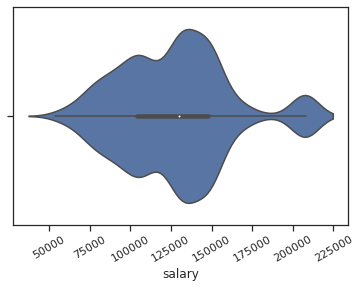

In [20]:
sns.violinplot(x="salary", data=data)
plt.xticks(rotation=30)
plt.show()

In [21]:
def Q(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """

    salary = row['salary']
    if salary < q1:
        return 1
    if (salary >= q1) & (salary < q2):
        return 2
    if (salary >= q2) & (salary < q3):
        return 3
    if salary >= q3:
        return 4
    else:
        return np.nan


data['target'] = data.apply( lambda row : Q(row), axis = 1)

A new target variable has been created and its values are nan, 1, 2, 3, and 4 - representing the unknown set, and four labels for the taget.

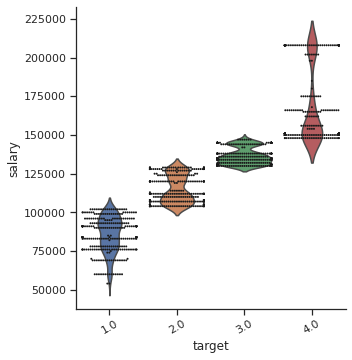

In [22]:
g = sns.catplot(x="target", y="salary", kind="violin", inner=None, data=data)
sns.swarmplot(x="target", y="salary", color="k", size=2, data=data, ax=g.ax)

plt.xticks(rotation=30)

plt.show()

<AxesSubplot:xlabel='salary'>

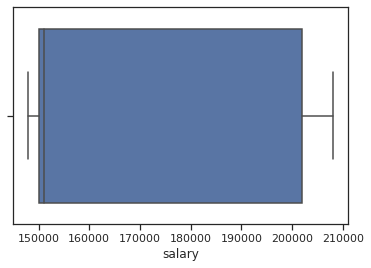

In [23]:
sns.boxplot(data=data[data.target == 4],x='salary')

And checking each target value for outliers

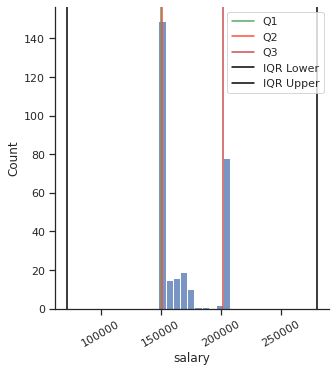

In [24]:
check = data[data.target == 4]
q1 = np.quantile(check.salary, 0.25)
q2 = np.quantile(check.salary, 0.5)
q3 = np.quantile(check.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(check.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.xticks(rotation=30)
plt.show()

'company'\
There's presently 96 different companies - that's a ton of dimensions added to the data, and I've still got to add count vectorizer. I'll try label encoding these. In the future, shifting these into clusters might be useful.\
Other than that, this variable doesn't seem to need much - 

In [25]:
data.company.value_counts()

sparkcognition                               80
comcentric                                   69
target                                       59
etsy                                         52
ericsson                                     50
                                             ..
claritas llc                                  1
international consulting associates, inc.     1
northrop grumman                              1
aureus group                                  1
liberty mutual insurance                      1
Name: company, Length: 96, dtype: int64

'rating'\
Roughly a third of the data is missing values for the company rating feature. At first I used np.fillna(0) to imput 0 for all the missing values but that sharply right-skewed the distribution towards zero.\
Then I checked is scaling the data would fix the bi-modality but I think I have two options here, drop all those records or drop a potentially valuable feature.\
For now, I'll drop the records, I can always get more, and in the future I could conduct linear regression to imput the values.

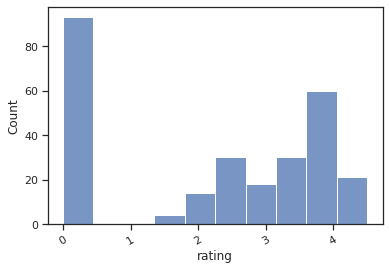

In [26]:
#TODO imput the rating with a regressor.
sns.histplot(data=data[data.target ==1], x='rating')
plt.xticks(rotation=30)
plt.show()

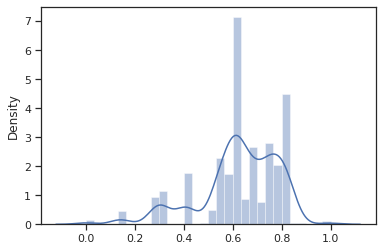

In [31]:
scale = MinMaxScaler()
scale = scale.fit_transform(pd.DataFrame(data['rating']))
sns.distplot(scale)
plt.show()

In [32]:
data = data[data.rating > 0]
len(data)

1030

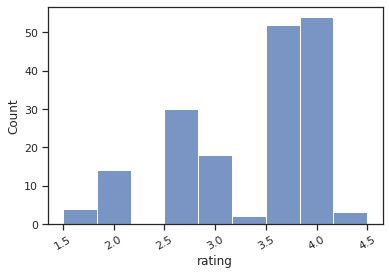

In [33]:
sns.histplot(data=data[data.target ==1], x='rating')
plt.xticks(rotation=30)
plt.show()

'job_title'\
Oddly enough, these number as many as company, I suspect multicolinearity. I'll come back to collapse these a bit and perhaps build a new feature for specializations out of these.
To be label encoded and possibly clustered later.

In [34]:
data.job_title.value_counts()

data scientist                                                     149
senior data scientist                                               79
machine learning engineer                                           49
associate data scientist                                            44
senior data scientist - routing algorithm                           39
                                                                  ... 
senior product manager- commerce                                     1
data analyst, senior (aqh, office of the assistant secretary...      1
client engineering data scientist (remote)                           1
data engineer - amazon distribution and grocery innovation           1
sr. principal / staff data scientist                                 1
Name: job_title, Length: 69, dtype: int64

'dateposted'
This isn't going into the pipelie, despite some interesting patterns, I don't think there's enough periodic/seasonality information available here. Still, great for visualizing the job market.

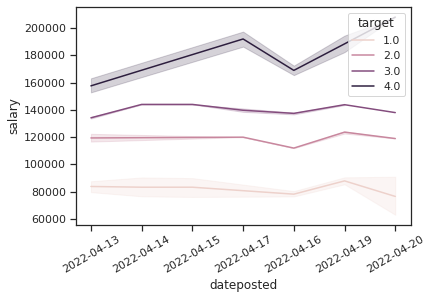

In [35]:
sns.lineplot(x="dateposted", y="salary", hue="target", data=data)
plt.xticks(rotation=30)
plt.show()

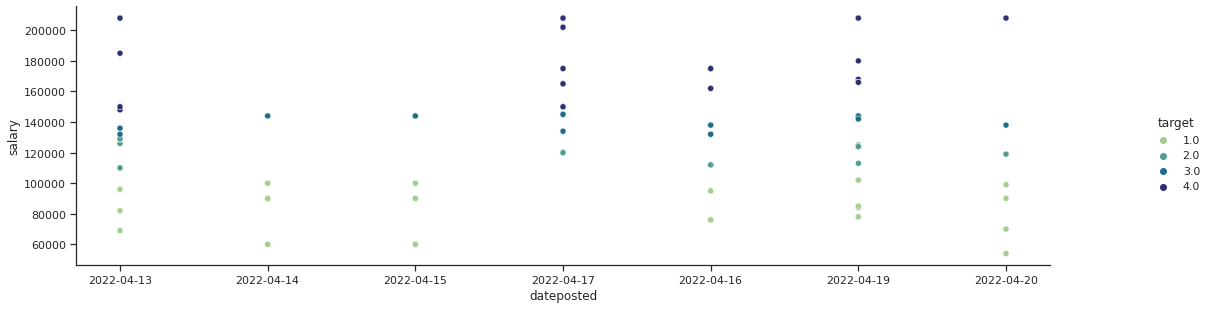

In [36]:
ax = sns.pairplot(data=data,
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)

In [37]:
len(data.city.value_counts())

44

In [38]:
len(data.state.value_counts())

29

## Feature Associations

In [39]:
data2 = data.drop('salary', axis=1)
data2.dropna(inplace=True)

In [40]:
target = 'target'

associated = []

for i in data2.select_dtypes('number').columns:
    if i == target:
        continue
    else:
        pearson_cor, pval = pearsonr(data2[i],data2[target])

    if pearson_cor > .3:
        associated.append([i,pearson_cor])

# Extracting column names of the dependent variables that passed the pearson correlation test of being at least .3
num_cols = []
for i in associated:
    num_cols.append(i[0])
num_cols

[]

As anticipated, rating passes the pearson test.

In [41]:

#TODO complete this by collecting the most significant colinear features and possibl removing them.

score_dictionary = {}
for i in data.select_dtypes('object').columns:
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    score_dictionary[i] = round(chi2,2)
score_df = pd.DataFrame(score_dictionary.items(), columns=['feature','chi2 score']).sort_values('chi2 score', ascending=False)
score_df[:-1]

,feature,chi2 score
1,description,2043.00
6,url,2043.00
7,text,2043.00
4,summary,1951.85
0,company,1757.75
5,job_title,1689.85
2,location,1326.30
10,city,1302.02
9,state,972.40
8,dateposted,221.34


Greater variance betewwen values leads to higher scores, apparently. 'text' is next.

In [42]:
data[['company','job_title','text']] = data[['company','job_title','text']].astype(str)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 0 to 1506
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       1030 non-null   object 
 1   description   1030 non-null   object 
 2   location      1030 non-null   object 
 3   rating        1030 non-null   float64
 4   requirements  104 non-null    object 
 5   summary       1030 non-null   object 
 6   job_title     1030 non-null   object 
 7   url           1030 non-null   object 
 8   text          1030 non-null   object 
 9   salary        681 non-null    float64
 10  dateposted    1030 non-null   object 
 11  state         1030 non-null   object 
 12  city          1030 non-null   object 
 13  target        681 non-null    float64
dtypes: float64(3), object(11)
memory usage: 120.7+ KB


In [44]:
data.to_csv(f'../app/data/processed_data.csv', index=False)